<h1>Decision Trees</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from IPython.display import HTML

<h2>Decision Tree Classifier</h2>

<p>This notebook is dedicated to performing Decision Tree algorithm for classification and regression. We will start with the classification. To build a decision tree, we use the CART algorithm (classification and regression tree). Briefly, it consists in finding the best splitting of data by a certain threshold and repeating this action until the data is exhausted. To find the best split we use one of the criterions: Gini impurity \begin{equation} \large G = 1 - \sum_{i=1}^{n} p_i^2 \end{equation} or Entropy \begin{equation} \large S = - \sum_{i=1}^{n} p_i \cdot log_2(p_i) \end{equation}</p>

In [2]:
class DecisionTree():
    '''
    DecisionTree class is used to permorm CART algorithm for Decision Tree Classifier.
    *****************************************************************************************
    Attributes:
    criterion - string; which criterion is used for splitting the data ('gini', 'entropy')
    max_depth - int; adjusts the depth of the tree
    min_samples_split - int; set the minimum size to split
    *****************************************************************************************
    Methods:
    make_dataset - from X and y makes one matrix
    criterion_value - depend on the attribute criterion counts the criterion value of two splits
    test_split - split the dataset into two groups with the threshold 
    get_split - find the best split using the best criterion value
    to_terminal - make the final node
    split - build the tree, recursively
    fit - starts the tree building
    print_tree - print the tree
    predict_row - predict the row of data using the tree
    predict - predict the whole data
    '''
    def __init__(self, criterion='gini', max_depth=np.infty, min_samples_split=2):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def make_dataset(self, X, y):
        return np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    def criterion_value(self, groups, classes):
        n_instances = sum(group.shape[0] for group in groups)
        if self.criterion == 'gini':
            criterion = 0
            for group in groups:
                size = len(group)
                if size == 0:
                    continue
                score = 0
                for class_val in classes:
                    p = [row[-1] for row in group].count(class_val) / size
                    score += p * p
                criterion += (1 - score) * (size / n_instances)
        elif self.criterion == 'entropy':
            dset = np.array([])
            s0 = 0
            for group in groups:
                if len(group) == 0:
                    continue
                shape = group.shape[1]
                dset = np.append(dset, group)
            dset = dset.reshape(-1, shape)
            for class_val in classes:
                p = [row[-1] for row in dset].count(class_val) / n_instances
                s0 += -p * np.log2(p)
            criterion = s0
            for group in groups:
                size = len(group)
                if size == 0:
                    continue
                score = 0
                for class_val in classes:
                    p = [row[-1] for row in group].count(class_val) / size
                    if p == 0:
                        score += 0.
                    else:
                        score += -p * np.log2(p)
                criterion -= score * (size / n_instances)
        else:
            raise AttributeError('There\'s no such criterion, choose between \'gini\' and \'entropy\'')
        return criterion

    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def get_split(self, dataset):
        class_values = list(set(row[-1] for row in dataset))
        if self.criterion == 'gini':
            b_index, b_value, b_score, b_groups, criterion_value_history = np.infty, np.infty, np.infty, None, []
        elif self.criterion == 'entropy':
            b_index, b_value, b_score, b_groups, criterion_value_history = np.infty, np.infty, 0, None, []
        for index in range(len(dataset[0]) - 1):
            for row in dataset:
                groups = self.test_split(index, row[index], dataset)
                criterion = self.criterion_value(groups, class_values)
                criterion_value_history.append(criterion)
                if self.criterion == 'gini':
                    if criterion < b_score:
                        b_index, b_value, b_score, b_groups = index, row[index], criterion, groups
                elif self.criterion == 'entropy':
                    if criterion >= b_score:
                        b_index, b_value, b_score, b_groups = index, row[index], criterion, groups
        if len(set(criterion_value_history)) == 1: # checking if there's no need to split dataset
            b_groups = self.test_split(0, min(dataset[:, 0]), dataset)
        try:
            b_value = (b_value + max(b_groups[0][:, b_index])) / 2
        except IndexError:
            pass
        return {'index':b_index, 'value':b_value, 'groups':b_groups, 'score':b_score}

    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)

    def split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])
        if len(left) == 0 or len(right) == 0:
            node['left'] = node['right'] = self.to_terminal(np.array(left.tolist() + right.tolist()))
            return
        if depth >= self.max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        if len(left) < self.min_samples_split:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            self.split(node['left'], depth+1)
        if len(right) < self.min_samples_split:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            self.split(node['right'], depth+1)
            
    def fit(self, X, y):
        train = self.make_dataset(X, y)
        root = self.get_split(train)
        self.split(root, 1)
        self.node = root

    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('{0}[X[{1}] < {2}]'.format(depth * '>', node['index'], np.round(node['value'], 3)))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('{0}[{1}]'.format('   ' + depth * '>', node))
    
    def predict_row(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict_row(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_row(node['right'], row)
            else:
                return node['right']
            
    def predict(self, X):
        predictions = []
        for row in X:
            predictions.append(self.predict_row(self.node, row))
        return np.array(predictions).reshape(1, -1)

<p>To look at the performance of our algorithm we will upload the iris dataset.</p>

In [3]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

<p>Or we can do it using the moons.</p>

In [4]:
# X, y = make_moons(100, noise=0.6, random_state=53)

<p>Let's create the tree and fit it with data. Here we won't use any stopping criteria.</p>

In [5]:
tree = DecisionTree(criterion = 'entropy')
tree.fit(X, y)

<p>Plot the predictions.</p>

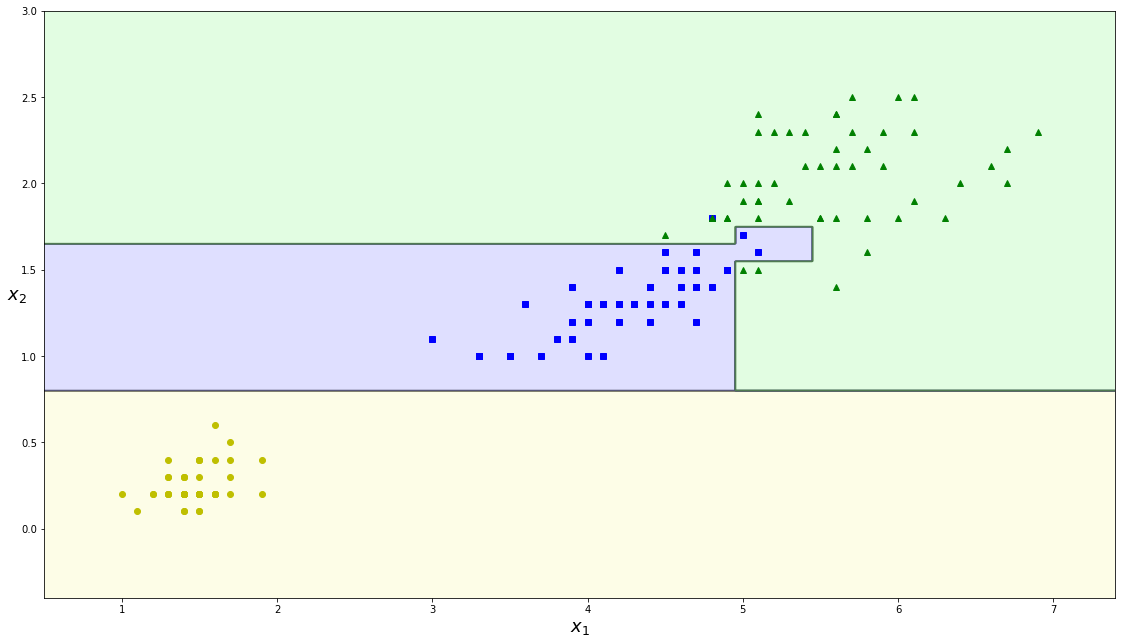

In [6]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(tree, X, y, axes = [X[:, 0].min() - 0.5, X[:, 0].max() + 0.5,\
                                           X[:, 1].min() - 0.5, X[:, 1].max() + 0.5])

plt.show()

<p>And comparison with sklearn.</p>

In [7]:
skl_tree = DecisionTreeClassifier(criterion='entropy')
skl_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

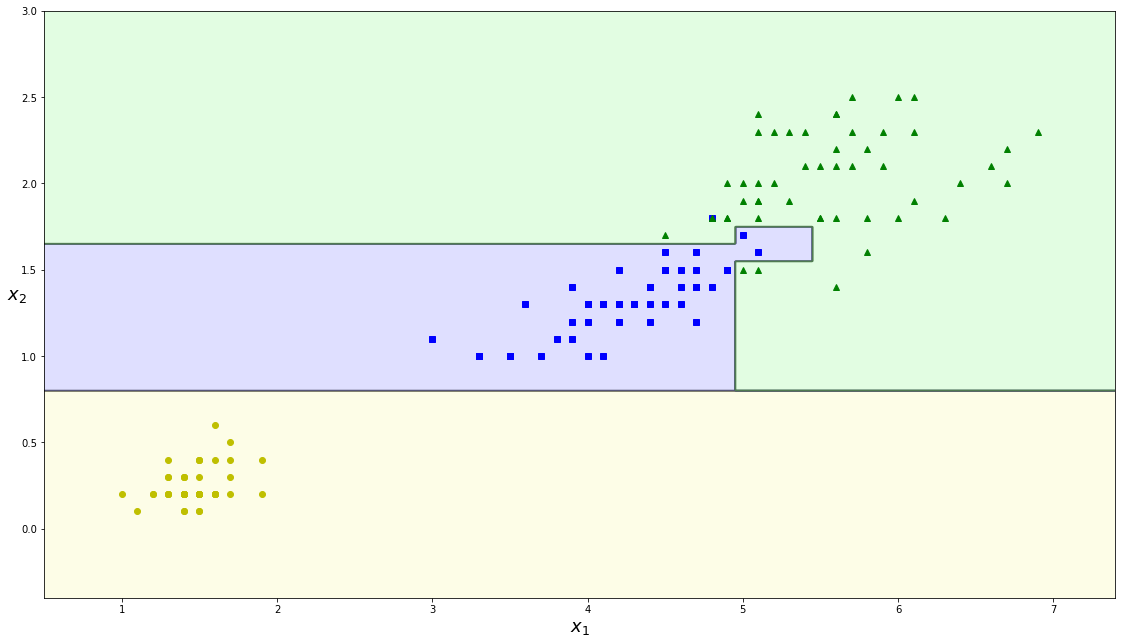

In [8]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(skl_tree, X, y, axes = [X[:, 0].min() - 0.5, X[:, 0].max() + 0.5,\
                                           X[:, 1].min() - 0.5, X[:, 1].max() + 0.5])

plt.show()

In [9]:
tree.print_tree(tree.node)

[X[1] < 0.8]
>[X[1] < 0.2]
   >>[0.0]
   >>[0.0]
>[X[1] < 1.75]
>>[X[0] < 4.95]
>>>[X[1] < 1.65]
>>>>[X[1] < 1.3]
   >>>>>[1.0]
   >>>>>[1.0]
   >>>>[2.0]
>>>[X[1] < 1.55]
>>>>[X[1] < 1.4]
   >>>>>[2.0]
   >>>>>[2.0]
>>>>[X[0] < 5.45]
>>>>>[X[1] < 1.6]
   >>>>>>[1.0]
   >>>>>>[1.0]
   >>>>>[2.0]
>>[X[0] < 4.85]
>>>[X[1] < 1.8]
   >>>>[2.0]
   >>>>[2.0]
>>>[X[1] < 1.8]
   >>>>[2.0]
   >>>>[2.0]


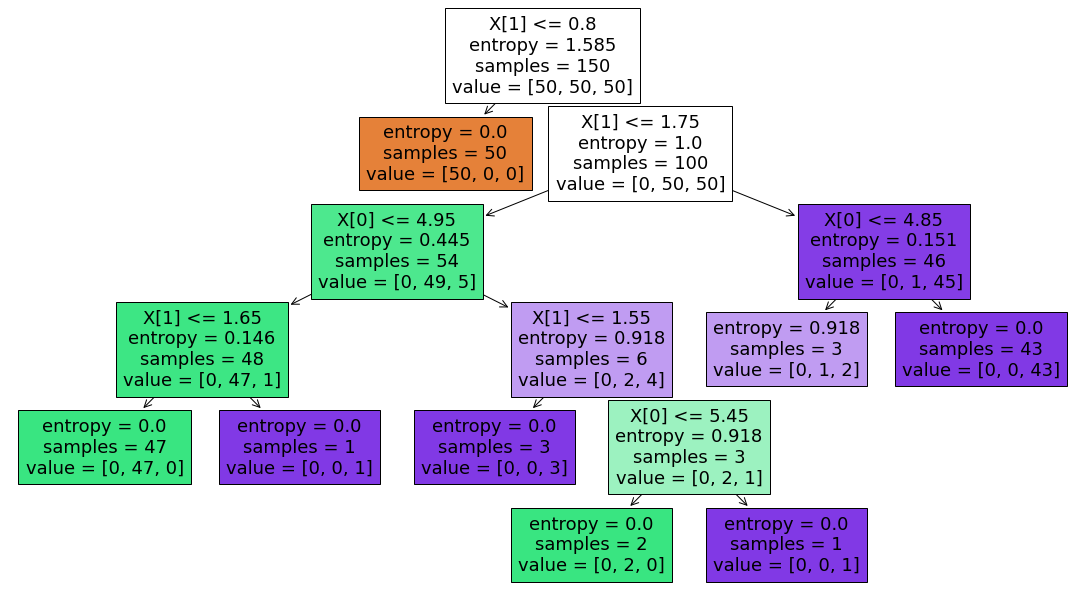

In [10]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
plot_tree(skl_tree, filled=True, ax=ax)
plt.show()

In [11]:
(tree.predict(X) == skl_tree.predict(X))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

<h2>Decision Tree Regressor</h2>

<p>We implement the construction of a decision tree for the regression problem. The tree is constructed in the same way as for the classification problem, but the function we minimize here uses MSE:
\begin{equation} \large \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} \end{equation}
where \begin{equation}
    \large
    \begin{cases}
    MSE_{node} = \sum\limits_{i}(\widetilde{y} - y_{i})\\
    \widetilde{y} = \frac{1}{m_{node}} \sum\limits_{i} y_{i}
    \end{cases}
    \end{equation}
and m is amount of elements in a group.</p>

In [12]:
class DecisionTreeReg():
    '''
    DecisionTreeReg class is used to permorm CART algorithm for Decision Tree Regressor.
    *****************************************************************************************
    Attributes:
    max_depth - int; adjusts the depth of the tree
    min_samples_split - int; set the minimum size to split
    *****************************************************************************************
    Methods:
    make_dataset - from X and y makes one matrix
    MSE - count the MSE
    test_split - split the dataset into two groups with the threshold 
    get_split - find the best split using the best criterion value
    to_terminal - make the final node
    split - build the tree, recursively
    fit - starts the tree building
    print_tree - print the tree
    predict_row - predict the row of data using the tree
    predict - predict the whole data
    '''
    def __init__(self, max_depth=np.infty, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def make_dataset(self, X, y):
        return np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    def MSE(self, groups):
        n_instances = sum(group.shape[0] for group in groups)
        criterion = 0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = sum([row[-1] for row in group]) / size
            criterion += sum((score - [row[-1] for row in group]) ** 2) * (size / n_instances)
        return criterion

    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def get_split(self, dataset):
        b_index, b_value, b_score, b_groups, MSE_history = np.infty, np.infty, np.infty, None, []
        for index in range(len(dataset[0]) - 1):
            for row in dataset:
                groups = self.test_split(index, row[index], dataset)
                criterion = self.MSE(groups)
                MSE_history.append(criterion)
                if criterion <= b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], criterion, groups
        if len(set(MSE_history)) == 1: # checking if there's no need to split dataset
            b_groups = self.test_split(0, min(dataset[:, 0]), dataset)
        try:
            b_value = (b_value + max(b_groups[0][:, b_index])) / 2
        except IndexError:
            pass
        return {'index':b_index, 'value':b_value, 'groups':b_groups}

    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return sum(outcomes) / len(outcomes)

    def split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])
        if len(left) == 0 or len(right) == 0:
            node['left'] = node['right'] = self.to_terminal(np.array(left.tolist() + right.tolist()))
            return
        if depth >= self.max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        if len(left) < self.min_samples_split:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            self.split(node['left'], depth+1)
        if len(right) < self.min_samples_split:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            self.split(node['right'], depth+1)
            
    def fit(self, X, y):
        train = self.make_dataset(X, y)
        root = self.get_split(train)
        self.split(root, 1)
        self.node = root

    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('{0}[X[{1}] < {2}]'.format(depth * '>', node['index'], np.round(node['value'], 3)))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('{0}[{1}]'.format('   ' + depth * '>', node))
    
    def predict_row(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict_row(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_row(node['right'], row)
            else:
                return node['right']
            
    def predict(self, X):
        predictions = []
        for row in X:
            predictions.append(self.predict_row(self.node, row))
        return np.array(predictions).reshape(1, -1)

In [13]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

<p>Here we build the retrained tree.</p>

In [14]:
reg_tree = DecisionTreeReg()
reg_tree.fit(X, y)

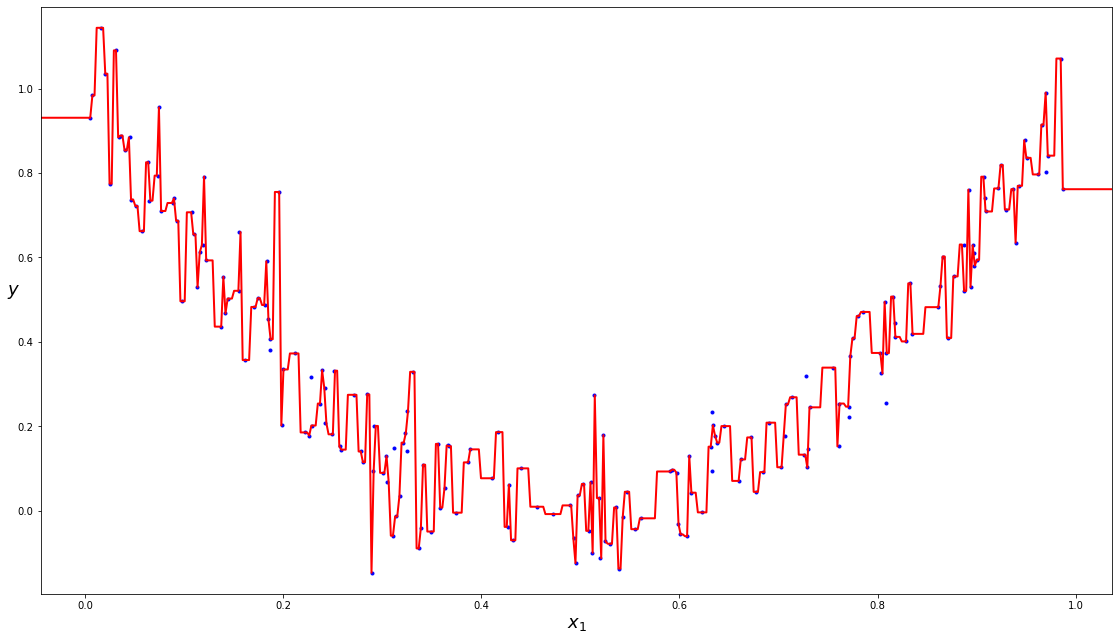

In [15]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred.reshape(-1, 1), "r-", linewidth=2)

plt.figure(figsize=(19.20, 10.80))
plot_regression_predictions(reg_tree, X, y, axes = [X[:, 0].min() - 0.05, X[:, 0].max() + 0.05,\
                                           y[:, 0].min() - 0.05, y[:, 0].max() + 0.05])

In [16]:
from sklearn.tree import DecisionTreeRegressor
skl_reg = DecisionTreeRegressor()
skl_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

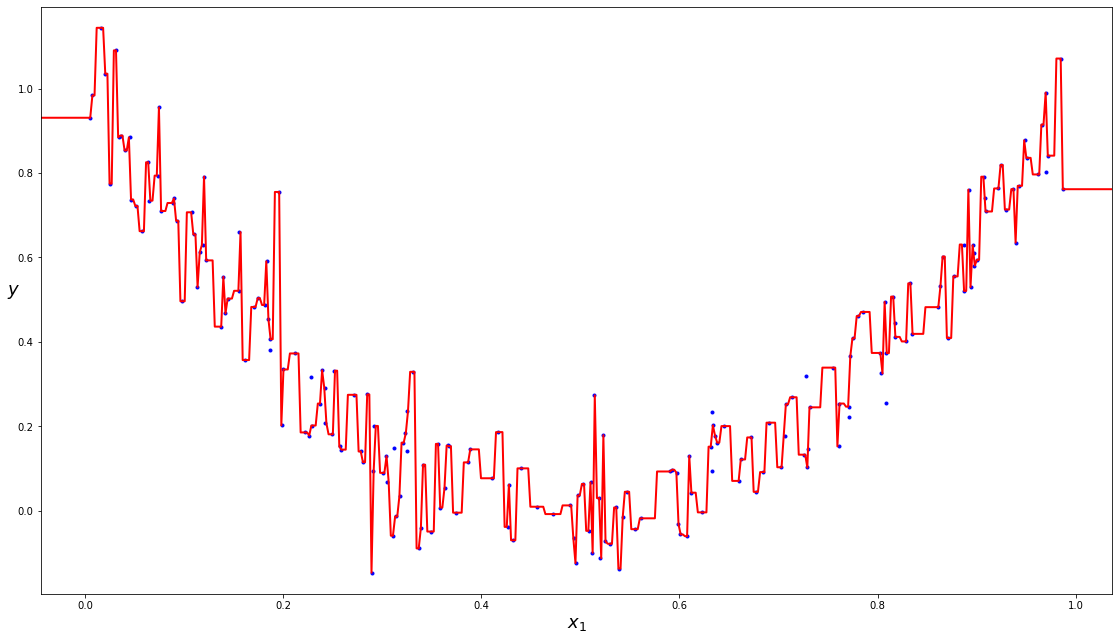

In [17]:
plt.figure(figsize=(19.20, 10.80))
plot_regression_predictions(skl_reg, X, y, axes = [X[:, 0].min() - 0.05, X[:, 0].max() + 0.05,\
                                           y[:, 0].min() - 0.05, y[:, 0].max() + 0.05])

In [18]:
(reg_tree.predict(X) == skl_reg.predict(X))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [19]:
with open('./style.css', 'r') as f:
    style = f.read()
HTML(style)